<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/5.1-LSTM-misclassification-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miscategorized Reviews by LSTM

In previous notebooks, we filtered and trained LSTM network with 16 nodes based on original sample size of 1 million samples

Variations and links to notebooks:


* [1 and 5 star ratings](deep_learning/6.6.3-LSTMB16_15-GloVe-1m-prototype.ipynb)
* [1, 4, 5 star ratings](deep_learning/6.7.3-LSTMB16_145-GloVe-1m-prototype.ipynb)
* [1, 3, 4, 5 star ratings](deep_learning/6.8.3-LSTMB16_1345-GloVe-1m-prototype.ipynb)
* [All star ratings](deep_learning/6.5.3-LSTMB16-GloVe-1m-prototype.ipynb)

In this notebook, we will look at the model performance as well as look at specific reviews that were miscategorized

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


''

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import json
from pprint import pprint


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=1.5)


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False

pd.set_option("max_colwidth", 300)
REPORT_FILE = f'{DRIVE_DIR}/reports/glove_embedding_with_stop-dl_prototype-report.csv'



Read in report file

In [0]:
report = pd.read_csv(REPORT_FILE, quotechar="'")
report["train_examples"] = report.train_examples.astype(int)
# 1-star and 5-star only
lstm_15 = report[report.model_name == "LSTMB16_15"].copy().reset_index()
# 1-star, 4-star, and 5-star
lstm_145 = report[report.model_name == "LSTMB16_145"].copy().reset_index()
# 1-star, 3-star, 4-star, and 5-star
lstm_1345 = report[report.model_name == "LSTMB16_1345"].copy().reset_index()
# all reviews
lstm_all = report[report.model_name == "LSTMB16"].copy().reset_index()

data_file = lstm_15.file.values[0]

# Fix Classification Report For Various Runs

Have to remap classes from classification to the real class labels

In [0]:
# map 2->5
cr15 = json.loads(lstm_15.classification_report.values[0])
cr15["5"] = cr15.pop("2")
lstm_15.loc[lstm_15.index, "classification_report"] = json.dumps(cr15)
lstm_15["label"] = "1,5 Star"
lstm_15 = ru.convert_dnn_report_format(lstm_15)

# map 3->5, 2->4
cr145 = json.loads(lstm_145.classification_report.values[0])
cr145["5"] = cr145.pop("3")
cr145["4"] = cr145.pop("2")
lstm_145.loc[lstm_145.index, "classification_report"] = json.dumps(cr145)
lstm_145["label"] = "1,4,5 Star"
lstm_145 = ru.convert_dnn_report_format(lstm_145)

# map 4->5, 3->4, 2->3
cr1345 = json.loads(lstm_1345.classification_report.values[0])
cr1345["5"] = cr1345.pop("4")
cr1345["4"] = cr1345.pop("3")
cr1345["3"] = cr1345.pop("2")
lstm_1345.loc[lstm_1345.index, "classification_report"] = json.dumps(cr1345)
lstm_1345["label"] = "1,3,4,5 Star"
lstm_1345 = ru.convert_dnn_report_format(lstm_1345)


lstm_all["label"] = "All"
lstm_all = ru.convert_dnn_report_format(lstm_all)

## Calculate Scores For Our Models

In [0]:
lstm_15["eval_metric"] = 2 / (1 / lstm_15["1_precision"] + 1 / lstm_15["5_precision"])
lstm_145["eval_metric"] = 3 / (1 / lstm_145["1_precision"] + 1 / lstm_145["4_recall"] + 1 / lstm_145["5_precision"])
lstm_1345["eval_metric"] = 4 / (1 / lstm_1345["1_precision"] + 
                               1 / lstm_1345["3_recall"] + 
                               1 / lstm_1345["4_recall"] + 
                               1 / lstm_1345["5_precision"])
lstm_all["eval_metric"] = 5 / (1 / lstm_all["1_precision"] + 
                               1 / lstm_all["2_recall"] + 
                               1 / lstm_all["3_recall"] + 
                               1 / lstm_all["4_recall"] + 
                               1 / lstm_all["5_precision"])

In [0]:
report_all = pd.DataFrame()
report_all = report_all.append(lstm_15, sort=False)
report_all = report_all.append(lstm_145, sort=False)
report_all = report_all.append(lstm_1345, sort=False)
report_all = report_all.append(lstm_all, sort=False)

# Print Model Scores

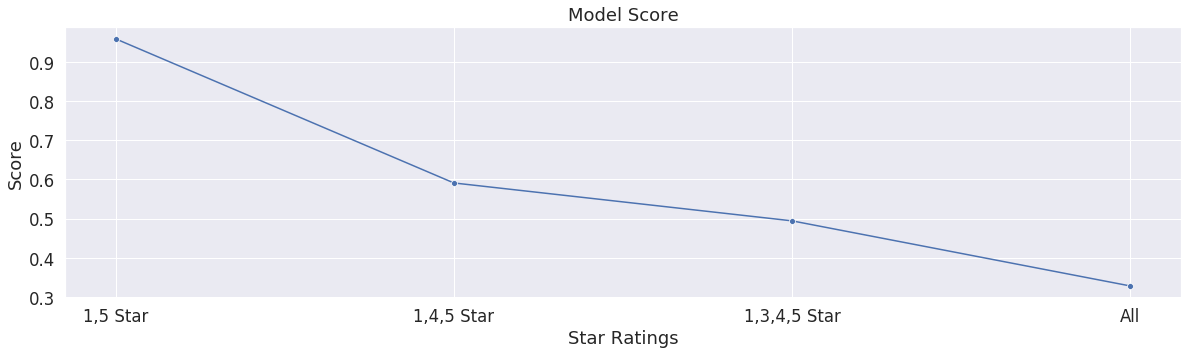

In [8]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(report_all.label, report_all.eval_metric, marker="o", sort=False)
_ = a.set_title("Model Score")
_ = a.set_xlabel("Star Ratings")
_ = a.set_ylabel("Score")

# Classification Report

* Recall stays roughly the same across
* Precision drops as we introduce more classes
  * 1-star and 3-star review precision drops pretty quickly as we introduct more classes

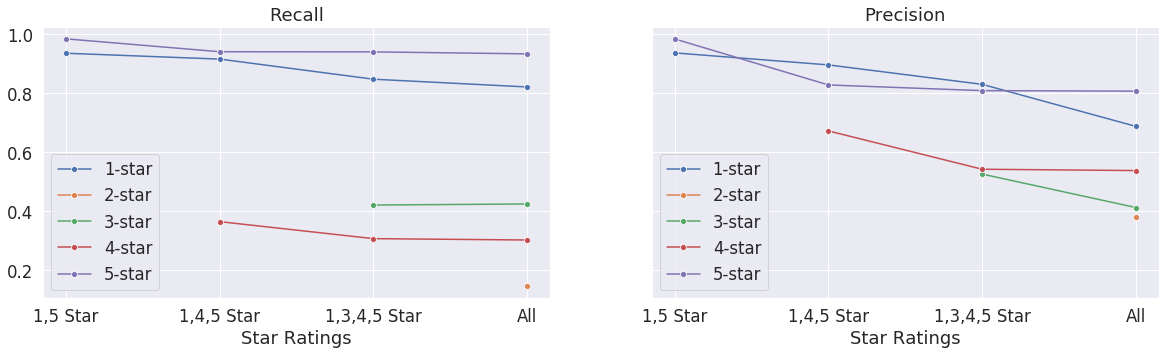

In [9]:
f, a = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
sns.lineplot(report_all.label, report_all["1_recall"], sort=False, label="1-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["2_recall"], sort=False, label="2-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["3_recall"], sort=False, label="3-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["4_recall"], sort=False, label="4-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["5_recall"], sort=False, label="5-star", marker="o", ax=a[0])
_ = a[0].set_xlabel("Star Ratings")
_ = a[0].set_ylabel("")
_ = a[0].set_title("Recall")

sns.lineplot(report_all.label, report_all["1_precision"], sort=False, label="1-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["2_precision"], sort=False, label="2-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["3_precision"], sort=False, label="3-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["4_precision"], sort=False, label="4-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["5_precision"], sort=False, label="5-star", marker="o", ax=a[1])
_ = a[1].set_xlabel("Star Ratings")
_ = a[1].set_ylabel("")
_ = a[1].set_title("Precision")

# Confusion Matrix For Various Runs

## 1-star and 5-star Only

* This is our baseline. We do have some 1-star misclassified as 5-star and vice versa but numbers look pretty reasonable. < 10% for both classes.

In [10]:
pd.DataFrame(json.loads(lstm_15.confusion_matrix.values[0])).rename({0: 1, 1: 5}, axis=1)

,1,5
0,32605,2285
1,2242,131649


## 1-star, 4-star, 5-star

* 1-star most likely misclassified as 5-star
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [11]:
pd.DataFrame(json.loads(lstm_145.confusion_matrix.values[0])).rename({0: 1, 2: 5, 1: 4}, axis=1)

,1,4,5
0,32021,1068,1920
1,2007,15086,24385
2,1751,6323,125748


## 1-star, 3-star, 4-star, 5-star

* 1-star most likely misclassified as 3-star
* <b>3-star most likely misclassified as 4-star (but 1 and 5 are pretty close)</b>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [12]:
pd.DataFrame(json.loads(lstm_1345.confusion_matrix.values[0])).rename({0: 1, 1: 3, 2: 4, 3: 5}, axis=1)

,1,3,4,5
0,29495,2987,413,1948
1,4041,9568,4664,4507
2,980,4205,12645,23480
3,1060,1466,5636,125839


## All star ratings

* 1-star most likely misclassified as 3-star
* <b>2-star most likely misclassified as 1-star, 2-star is more likely to be misclassified as 1-star than itself</b>
* <b>3-star most likley misclassified as 5-star, then 4-star and 1-star</b>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [13]:
pd.DataFrame(json.loads(lstm_all.confusion_matrix.values[0])).rename({0: 1, 1: 2, 2: 3, 3: 4, 4: 5}, axis=1)

,1,2,3,4,5
0,28724,1969,2486,249,1591
1,7608,2420,4668,668,1236
2,3319,1542,9435,3982,3993
3,936,305,4613,12555,23226
4,1248,144,1726,5933,124845


# Look at Specific Reviews That Are Misclassified

In [14]:
# Read data file - we know they all started with the same data file so let's just pick one to start with
DATA_FILE = lstm_15.file.values[0]
print(f'Reading datafile: {DATA_FILE}')
df = pd.read_csv(DATA_FILE, encoding='utf8', engine='python')

Reading datafile: drive/My Drive/Springboard/capstone/data/amazon_reviews_us_Wireless_v1_00-1m-with_stop-preprocessed.csv


# 1-Star and 5-Star Only

In [0]:
MAX_SEQUENCE_LENGTH = 100

def load_and_predict(report: pd.DataFrame, reviews_test):
  """
  :param report: report DF
  :param classes: list of classes to keep
  """
  print(f'Loading tokenizer file: {report.tokenizer_file.values[0]}')
  with open(report.tokenizer_file.values[0], 'rb') as file:
    t = pickle.load(file)

  # Pre-process our features (review body)
  # t = Tokenizer(oov_token="<UNK>")
  # fit the tokenizer on the documents
  # t.fit_on_texts(reviews_train)
  # tokenize both our training and test data
  test_sequences = t.texts_to_sequences(reviews_test)

  print("Vocabulary size={}".format(len(t.word_counts)))
  print("Number of Documents={}".format(t.document_count))


  # pad our reviews to the max sequence length
  X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Test review vectors shape:', X_test.shape)

  print(f'Loading model file: {report.model_file.values[0]}')
  model = load_model(report.model_file.values[0])
  print(f'Predicting test set...')
  y_predict = model.predict(X_test)

  print(f'Unencoding predictions...')
  y_predict_unencoded = ku.unencode(y_predict)

  return model, y_predict, y_predict_unencoded




### Incorrect Results For 1-Star and 5-Star only

* Unmap predictions to original star ratings
* merge with reviews so we can look at the text

In [16]:
# predict 15
df_15 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 5)]
# have to set 5's to 2's so we can compute class weights later
df_15.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 2
CLASSES = 2

ratings_15 = df_15[LABEL_COLUMN]
reviews_15 = df_15[REVIEW_COLUMN]

reviews_train_15, reviews_test_15, y_train_15, y_test_15 = train_test_split(reviews_15, ratings_15, random_state=1)

model_15, y_predict_15, y_predict_unencoded_15 = load_and_predict(lstm_15, reviews_test_15)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove_with_stop-sampling_none-675121-100-star_rating-tokenizer.pkl
Vocabulary size=83300
Number of Documents=506340
Test review vectors shape: (168781, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove_with_stop-sampling_none-675121-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_15(y_unencoded: pd.DataFrame):
  # unmap preidctions 2->5
  y_unencoded.loc[results_15.true_15 == 2, "true_15"] = 5
  y_unencoded.loc[results_15.predict_15 == 2, "predict_15"] = 5
  return y_unencoded


results_15 = pd.DataFrame({"true_15": y_test_15, "predict_15": y_predict_unencoded_15})
unmap_15(results_15)

results_15 = results_15.join(reviews_test_15).reset_index().rename({"index": "index_orig"}, axis=1)


In [18]:
results_15[results_15.true_15 != results_15.predict_15].head(10)

,index_orig,true_15,predict_15,review_body
19,947004,1,5,very misleading this is not an otterbox like i have purchased from the store it doe not say otterbox on it it is not made like an otterbox either it is kind of a knock off the clear plastic insterts that cover the camera lens you have to glue these on yourself it is like performing surgery cause...
30,875542,5,1,the mount work great and look real nice the wire for it deffinently wa a rip off though they also had no wireing diagram so if you cant use a voltmeter wire and mount are kind of worthless
61,528773,5,1,after it wa in my drawer for a long ti ame i installed it on my htc and it is not that good all the corner and side have air in them like a long bubble and also in the bottom left corner the whole protector is turning up so a lot of dust got in there until it sticked it get scratch pretty easily...
85,326416,5,1,poor quality
117,587687,5,1,bought them for my worker and they are fine with it nobody report the product is bad not hard to use
154,756433,5,1,love the color and design of this case i would not recommend the case if you are looking for something that cover the front
163,357692,5,1,let me just say i dropped it in the tub and after being submersed for a minute or two i did not even have to worry about water leakage
178,823493,5,1,cant wait to get my dock extender to try it out just like previous one i bought through apple awesome and cheap but high quality
183,38302,1,5,the screen doe not extend edge to edge which may be why it cracked day two i am not careless with my phone the cover i had on my last phone lasted over a year without any damage i am here to order a replacement and wanted to leave a comment on why
193,762066,1,5,front rubber come out everyone i use the pen why would amazon let this pensell on their website site


# 1-Star, 4-Star, and 5-Star

In [19]:
# predict 145
df_145 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 4) | (df[LABEL_COLUMN] == 5)]
# have to set 4->2, 5->3
df_145.loc[df[LABEL_COLUMN] == 4, LABEL_COLUMN] = 2
df_145.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 3

ratings_145 = df_145[LABEL_COLUMN]
reviews_145 = df_145[REVIEW_COLUMN]

reviews_train_145, reviews_test_145, y_train_145, y_test_145 = train_test_split(reviews_145, ratings_145, random_state=1)

model_145, y_predict_145, y_predict_unencoded_145 = load_and_predict(lstm_145, 
                                                                     reviews_test_145)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop-sampling_none-841233-100-star_rating-tokenizer.pkl
Vocabulary size=98360
Number of Documents=630924
Test review vectors shape: (210309, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop-sampling_none-841233-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_145(y_encoded: pd.DataFrame):
  y_encoded.loc[y_encoded.true_145 == 2, "true_145"] = 4
  y_encoded.loc[y_encoded.true_145 == 3, "true_145"] = 5
  y_encoded.loc[y_encoded.predict_145 == 2, "predict_145"] = 4
  y_encoded.loc[y_encoded.predict_145 == 3, "predict_145"] = 5
  return y_encoded


results_145 = pd.DataFrame({"true_145": y_test_145, "predict_145": y_predict_unencoded_145})

# unmap preidctions 2->4, 3->5
# results_145.loc[results_145.true_145 == 2, "true_145"] = 4
# results_145.loc[results_145.true_145 == 3, "true_145"] = 5
# results_145.loc[results_145.predict_145 == 2, "predict_145"] = 4
# results_145.loc[results_145.predict_145 == 3, "predict_145"] = 5
unmap_145(results_145)

results_145 = results_145.join(reviews_test_145).reset_index().rename({"index": "index_orig"}, axis=1)


### Misclassified 1-Star Reviews

In [21]:
results_145[(results_145.true_145 == 1) & 
            (results_145.true_145 != results_145.predict_145)].head(10)

,index_orig,true_145,predict_145,review_body
7,165367,1,5,it is degree here in florida and the smart watch continuously show i must say i wish i hope that is wa just that one i am checking into the gear live watch maybe that will work for me
16,637381,1,5,i had it applied perfectly with a perfectly flush surface to surface contact but the stickiness only lasted a day they have sacrificed a sticky permanent surface for an endlessly redoable one
160,210353,1,5,what you are seeing on everyone el review is accurate the sound quality of these headphone is on par with a tin can and a string i bought a pair at the dollar store and chose the brand name over an equally priced competitor that i would never heard of i am regretting my decision i ammensely
226,929899,1,5,received this a a gift when i opened it it appear to be used not shiny and new now i know why amazon sent a replacement but it too looked used so i thought it wa just the terrible packaging of garmin and went to use it no satellite signal troubleshot the heck out of it calibrated it etc nothing ...
237,753082,1,5,update day beyond warranty one year and day after purchase the flip out stand ceased to remain closed the magnet in the stand became detached i stuck it back in but it will not stay in not that seidio would have done anything because they do not stand behind their product even from normal use it...
256,965049,1,4,my iphone dropped from mint condition after several week in this case i purchased it a a replacement to a si amilar seidio case whose clasp had broken off after about a year of use i loved this case but not the price at first glance i thought i had a great bargain with the casecrown model it fit...
374,880078,1,4,frustration is the keyword to describe this bluetooth earpiece because it will not stay on my head or in my ear this is not my first bluetooth unit my jabra and motorola have problem free earpiece human ear are certainly rich and varied in size and shape but that is a given not a surprise and th...
480,165662,1,5,way to small for an adult man
586,34964,1,4,doe not have built in blue tooth surely this unit doe an excellent job a a cd player and plug in usb medium player and the package came in good shape all part included new and clean i bought it specifically for the blue tooth however and wa very disappointed
675,184622,1,5,look very cheap color wa slightly off this is something a teeny bopper would love


### Misclassified 4-Star Reviews

* 4 misclassified as 5

In [22]:
results_145[(results_145.true_145 == 4) & 
            (results_145.predict_145 == 5) & 
            (results_145.true_145 != results_145.predict_145)].head(20)

,index_orig,true_145,predict_145,review_body
2,292311,4,5,work effectively just do not get a cri amp in them
4,569553,4,5,used 2 out of the pack a far a i can tell they do the job would buy again if i did not hate the phone
23,814850,4,5,this is a lovely cellphone case that really protects my phone and it wa very affordable i am very pleased with it
26,783777,4,5,bought this case for my i phone 4 and it fit perfect it keep my phone from getting scratch it is durable
29,280042,4,5,great for phone
30,746017,4,5,i have gotten so many compli ament over this case it is so tiny so it slide easily into my pocket too the shipping wa fast just be careful not to be a person dropping around your phone a lot plastic clip ons are more for look
45,684282,4,5,unit ha clear sound but switching to fm could be a choir and hard to hear caller with window open while driving i would recommend this unit to others
57,623423,4,5,this battery is amazing can not kill it all day now no matter what i do back cover is not perfect but it is not a bad a everyone here clai am the only problem i had is that the power button wa being constantly pressed i had to fix that myself other than that best 7 spend ever finally i can actua...
60,345057,4,5,work well grandson very pleased with product exceeds expectation
62,448612,4,5,these are helpful plenty in a package at a good price not a sticky a you would like though


* 4 misclassified as 1

In [23]:
results_145[(results_145.true_145 == 4) & 
            (results_145.predict_145 == 1) & 
            (results_145.true_145 != results_145.predict_145)].head(10)

,index_orig,true_145,predict_145,review_body
77,204145,4,1,doe not fit ulti amate phone
109,943114,4,1,everything pictured arrived exactly a seen it is been almost a year i think or more since my purchase and the screen guard ha remained in place despite the fact that it doe not initially fit correctly the small cylindrical shaped hole used for the ear speaker at the top wa actually placed too hi...
128,892926,4,1,i received this charger in the mail and i ammediately plugged it in to charge the battery it came with however much to my chagrin the light would come on and flash between amber and green then shut off thinking that the battery might be bad i tried it in my phone i wa unable to even power up the...
331,259822,4,1,only 4 start every thing ok why no battery came with
358,842844,4,1,bought for my senior parent to keep in car hoping they will use it if they get lost disoriented or have car failure phone emits beep when turned on then emergency button can be pushed and is dialed automatically phone emits a signal when the off button is pressed should be easy for them to use
424,429481,4,1,look cute but hard to push the button on the side through the case get what you pay for i guess
855,865437,4,1,didnt really think much of the gold ri amming doesnt look so flashy in the picture leather pattern is also kinda plasticy but i really like the design which is why i bought it and it just buck too
1130,336317,4,1,i wore this case for 3 month straight and it turned white at the edge and it started chipping and etc
1210,294593,4,1,i wa somewhat happy with this phone when i had it no bell whistle but you knew it wa a pretty tough little phone it took picture pretty good then it got stolen i hope the sli amy vermin choked on his own vomit
1240,75984,4,1,it helped that read the others review to apply because if you follow their direction you will think you are doing it wrong and get frustrated it went on easily enough with patience crystal clear with no bubble on the top one on the end but you hardly noticed i do not advise applying this product...


# 1-Star, 3-Star, 4-Star, 5-Star Ratings

In [24]:
# predict 1345
df_1345 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 3) | (df[LABEL_COLUMN] == 4) | (df[LABEL_COLUMN] == 5)]
# have to set 3->2, 4->3, 5->4
df_1345.loc[df[LABEL_COLUMN] == 3, LABEL_COLUMN] = 2
df_1345.loc[df[LABEL_COLUMN] == 4, LABEL_COLUMN] = 3
df_1345.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 4

ratings_1345 = df_1345[LABEL_COLUMN]
reviews_1345 = df_1345[REVIEW_COLUMN]

reviews_train_1345, reviews_test_1345, y_train_1345, y_test_1345 = train_test_split(reviews_1345, ratings_1345, random_state=1)

model_1345, y_predict_1345, y_predict_unencoded_1345 = load_and_predict(lstm_1345, 
                                                                     reviews_test_1345)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_1345-1x16-glove_with_stop-sampling_none-931734-100-star_rating-tokenizer.pkl
Vocabulary size=104931
Number of Documents=698800
Test review vectors shape: (232934, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_1345-1x16-glove_with_stop-sampling_none-931734-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_1345(y_encoded: pd.DataFrame):
  # unmap preidctions 2->3, 3->4, 4->5

  y_encoded.loc[y_encoded.true_1345 == 4, "true_1345"] = 5
  y_encoded.loc[y_encoded.true_1345 == 3, "true_1345"] = 4
  y_encoded.loc[y_encoded.true_1345 == 2, "true_1345"] = 3
  y_encoded.loc[y_encoded.predict_1345 == 4, "predict_1345"] = 5
  y_encoded.loc[y_encoded.predict_1345 == 3, "predict_1345"] = 4
  y_encoded.loc[y_encoded.predict_1345 == 2, "predict_1345"] = 3
  return y_encoded


results_1345 = pd.DataFrame({"true_1345": y_test_1345, "predict_1345": y_predict_unencoded_1345})

# results_1345.loc[results_1345.true_1345 == 4, "true_1345"] = 5
# results_1345.loc[results_1345.true_1345 == 3, "true_1345"] = 4
# results_1345.loc[results_1345.true_1345 == 2, "true_1345"] = 3
# results_1345.loc[results_1345.predict_1345 == 4, "predict_1345"] = 5
# results_1345.loc[results_1345.predict_1345 == 3, "predict_1345"] = 4
# results_1345.loc[results_1345.predict_1345 == 2, "predict_1345"] = 3
unmap_1345(results_1345)

results_1345 = results_1345.join(reviews_test_1345).reset_index().rename({"index": "index_orig"}, axis=1)

### Misclassified 3-Star Reviews

* 3 as 4

In [26]:
results_1345[(results_1345.true_1345 == 3) & 
            (results_1345.predict_1345 == 4) & 
             (results_1345.true_1345 != results_1345.predict_1345)].head(10)

,index_orig,true_1345,predict_1345,review_body
53,423802,3,4,look and feel amazing only gripe is that a few day in the edge started chipping i recommend using this with a case of your going buy so it can protect the edge
96,672600,3,4,go in an out someti ame can not here someti ames it ha static someti ame an the phone can be in your pocket an it still sound like it is breaking up not all tha ti ame but i think it is just dis headset
117,822267,3,4,i do not drop my phone or treat them like a toy but it did start to peel on the back after purchase
134,768691,3,4,it is a good case but to big for my samsung galaxyit arrived on ti ame but i can t really use it
410,743767,3,4,the lip surrounding the longer side of the screen is not raised much at all so i am concerned that if phone drop flat on the screen or on an uneven surface for example gravel there is a possibility the screen will scratch or crack along with others i would recommend a screen protector a a must h...
426,749313,3,4,i help nominally but i can not tell much difference between it and no antenna i get static when i expect a strong signal depends on which way i am pointing
450,662888,3,4,a case go this is not too bad i generally use an otterbox defender while i think the otterbox is far superior for protecting the phone i have used case like this the mostly protect the back of the phone while leaving the screen open the cost of more protection is the bulk it add to the size of t...
477,225870,3,4,good charger but cord need to be longer
478,648906,3,4,i like this cover because it interesting looking and it actually doe a pretty good job of prodecting my phone i am a person who tends to drop my phone and it ha not shattered or broken yet the only thing about this case is that the front part when you put it together tends to get caught on the s...
522,63147,3,4,very loose replacement function perfectly well but it easy to come off


* 3 as 1

In [27]:
results_1345[(results_1345.true_1345 == 3) & 
            (results_1345.predict_1345 == 1) & 
             (results_1345.true_1345 != results_1345.predict_1345)].head(10)

,index_orig,true_1345,predict_1345,review_body
3,479273,3,1,very cheaply made do not last long
123,623719,3,1,i bought this detector to replace my beltronics an older midrange model while the older unit did a great job of warning me about threat oftenti ames my passenger became irritated with all the false alarm driving around town this wa especially true of my girlfriend she initially rolled her eye wh...
194,738261,3,1,wa a good product and had me relying on it more and more unfortunately after 2 month of use it stopped working it will not charge up or give charge no led nothing customer support wa willing to give me a new one in exchange of the old one but i am on vacationing abroad this summer which mean i a...
322,870011,3,1,nice price good look i can not get the bluetooth to work streaming nor phonecalls no idea samsung galaxy s say it is paired pairing worked fine unit tell me nothing i am the only one using a galaxy s this is a very confusing unit menu are confusing i can not even figure out if the bluetooth is t...
327,617054,3,1,it wa tough to use a the clamp that hold the phone wa not well shaped and barely opened wide enough to fit the phone my i ampression is that this designed for a generic cellphone and not specifically for the fairly large galaxy note phone i ulti amately gave it away to someone else with a more n...
357,982415,3,1,i thought since these radio cost a little more than what we had been using they would be awesome i do not know if it is because our building is concrete or what but someti ames message do not go through to all radio also the cheap ear piece pretty much all snapped in the same place two day after...
443,733237,3,1,if you drop your phone slot this case is not for you mine ha been on for two day and is cracked and i did not drop it
485,583306,3,1,i love the way the case fit around my ipad perfect snug but the track where you put the bottom of your ipad into so it can stand up are too shallow so the weight of the ipad cause it to fall backward the cover the part with the track in it is too thin fli amsy so the slightest movement make the ...
503,108629,3,1,the clip broke the same day
514,931723,3,1,the case look very stylish i love the design but the physical construction leaf a bit to be desired the plastic band that fit around the iphone is a little fli amsy especially on the bottom around the usb connector port the plastic is very thin and break easy the first ti ame i put it around my ...


# All Star Ratings

In [28]:
# # predict 1345
# df_1345 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 3) | (df[LABEL_COLUMN] == 4) | (df[LABEL_COLUMN] == 5)]
# # have to set 3->2, 4->3, 5->4
# df_1345.loc[df[LABEL_COLUMN] == 3, LABEL_COLUMN] = 2
# df_1345.loc[df[LABEL_COLUMN] == 4, LABEL_COLUMN] = 3
# df_1345.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 4

ratings_all = df[LABEL_COLUMN]
reviews_all = df[REVIEW_COLUMN]

reviews_train_all, reviews_test_all, y_train_all, y_test_all = train_test_split(reviews_all, ratings_all, random_state=1)

model_all, y_predict_all, y_predict_unencoded_all = load_and_predict(lstm_all, 
                                                                     reviews_test_all)



Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-glove_with_stop-sampling_none-997682-100-star_rating-tokenizer.pkl
Vocabulary size=110014
Number of Documents=748261
Test review vectors shape: (249421, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-glove_with_stop-sampling_none-997682-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
results_all = pd.DataFrame({"true_all": y_test_all, "predict_all": y_predict_unencoded_all})

# don't have to unmap predictions

results_all = results_all.join(reviews_test_all).reset_index().rename({"index": "index_orig"}, axis=1)

In [30]:
y_test_all.head()

421030    2
402901    5
604078    5
740512    2
737066    5
Name: star_rating, dtype: int64

In [31]:
df.iloc[629436]

star_rating                                                                                                                                      5
helpful_votes                                                                                                                                    0
total_votes                                                                                                                                      0
review_headline                                                                                                                exactly a described
review_body        exactly a described never used though because i ended up doing a warranty exchange getting a new battery satisfied with product
review_date                                                                                                                             2014-01-22
Name: 629436, dtype: object

In [32]:
results_all[results_all.index_orig == 629436]

,index_orig,true_all,predict_all,review_body


### Misclassified Samples

* 1 as 5

In [33]:
results_all[(results_all.true_all == 1) & 
            (results_all.predict_all == 5) & 
             (results_all.true_all != results_all.predict_all)].head(10)

,index_orig,true_all,predict_all,review_body
422,872381,1,5,i knew what i wa getting before i ordered but that wa based solely on the first two product review not on the official product description it appears to be about 5 gauge wire not 4 the wire diameter is approxi amately inch here are the official awg wire size for reference 4 awg gauge 5 awg gauge...
596,800238,1,5,my husband tried all three and all three had to be trashed tried a pricey screen cover and no problem he had it on in le than a minute will not but these again
614,908098,1,5,i have yet to receive this order i realize it is coming from hong kong but it ha been about 5 week since the order
739,967529,1,5,this come up in the search for skin case and cover for your blackberry read the fine print it is a set of sticker and they charge 5 in shipping for something should ship in an envelope for 0
808,586211,1,5,i ordered this pouch to carry my samsung note 3 around my neck but got a totally different style one i would never have picked the measurement shown are smaller than described will not fit my note 3 with the otterbox i took a good deal of ti ame looking for something large enough for the phone w...
836,627372,1,5,wa not the correct size loved the case just what i wanted but to small all the rest ordered worked perfect
853,297393,1,5,i have problem they send me u staff i wa order new
1148,204265,1,5,do not purchase cheaply made only had it two month and it look like i had it for 3 year
1158,171792,1,5,it is not sweat proof what so ever i can not i amagine ever going out in the rain with this thing
1301,308883,1,5,so far i have not been able to pair it with anything what is the secret no instruction to help


# Join all Results Dataframe Into One

In [34]:
results_comprehensive = pd.merge(pd.merge(pd.merge(results_15.drop("review_body", axis=1), 
                                                results_145.drop("review_body", axis=1), how='outer', 
                                                left_on="index_orig", right_on="index_orig"),
                                      results_1345.drop("review_body", axis=1), how='outer', 
                                                left_on="index_orig", right_on="index_orig"),
                                      results_all, how='outer', 
                                                left_on="index_orig", right_on="index_orig")

results_comprehensive = results_comprehensive.dropna(subset=["review_body"])
results_comprehensive.head()



,index_orig,true_15,predict_15,true_145,predict_145,true_1345,predict_1345,true_all,predict_all,review_body
6,567377,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0,i love these connector they take a lot of the hassle of splicing stereo wire together i am very glad i found these on amazon
10,494240,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0,fast shipping great price
12,309913,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,did not fit the phone
14,333089,5.0,5.0,5.0,5.0,NaN,NaN,5.0,5.0,i love this case compact and efficient nice leather
15,450253,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0,future project


* we have 2k 5-star samples that were in all runs

In [35]:
results_comprehensive[(results_comprehensive.true_all == 5) &
                      results_comprehensive.true_15.notnull() &
                      results_comprehensive.true_145.notnull() &
                      results_comprehensive.true_1345.notnull()].shape

(1976, 10)

* we have 2.6k 4-star samples that were in all relevant runs

In [36]:
results_comprehensive[(results_comprehensive.true_all == 4) &
                      results_comprehensive.true_145.notnull() &
                      results_comprehensive.true_1345.notnull()].shape

(2583, 10)

* we have 5k 3-star samples that were in all relevant runs

In [37]:
results_comprehensive[(results_comprehensive.true_all == 3) &
                      results_comprehensive.true_1345.notnull()].shape

(5668, 10)

# Testing specifically what the model is doing

In [38]:
results_comprehensive[(results_comprehensive.true_145 == 4) & (results_comprehensive.predict_145 == 5)].head(20)

,index_orig,true_15,predict_15,true_145,predict_145,true_1345,predict_1345,true_all,predict_all,review_body
168801,783777,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,bought this case for my i phone 4 and it fit perfect it keep my phone from getting scratch it is durable
168804,280042,NaN,NaN,4.0,5.0,4.0,5.0,4.0,5.0,great for phone
168822,623423,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,this battery is amazing can not kill it all day now no matter what i do back cover is not perfect but it is not a bad a everyone here clai am the only problem i had is that the power button wa being constantly pressed i had to fix that myself other than that best 7 spend ever finally i can actua...
168825,345057,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,work well grandson very pleased with product exceeds expectation
168839,876180,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,love this case for my droid razr just wish itcame in another color besides black and pink also amazon ha best price for this case would definitely recommend this purchase
168881,688382,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,i have had my phone for year and the battery would not stay charged i could not find a battery near me and wa happy i wa able to get a new one at such a low price work great so far
168900,370874,NaN,NaN,4.0,5.0,4.0,3.0,4.0,4.0,when i transferred my day minute from a non smartphone tracfone i also got pot of text and data mb a nice bonus it is also nice that it come with a storage card installed it ha been pretty reliable snappy websurfing on either wifi or i also installed a few apps from google play without problem b...
168904,740083,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,these are wonderful case 5 in 1 you can even match them your outfit at a good price a well
168919,303307,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,bought for my momma defiantly be buying in a different color
168949,626852,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,after my cat swatted the fone into a cup of water the battery dy shortly after that this is a nice replacement and seems to last a long ti ame thank goodness the fone survived


In [39]:
review_temp = ['this is a really good product']

_, y_predict_temp, y_predict_unencoded_temp = load_and_predict(lstm_145, review_temp)



print(y_predict_temp)
print(y_predict_unencoded_temp)

Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop-sampling_none-841233-100-star_rating-tokenizer.pkl
Vocabulary size=98360
Number of Documents=630924
Test review vectors shape: (1, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop-sampling_none-841233-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...
[[6.9829519e-04 1.7275687e-01 8.2654476e-01]]
[3]


In [40]:
print(datetime.now())

2020-02-22 22:19:28.756672
